# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install matplotlib
# !pip install seaborn
# !pip install optuna

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # Hard augmentation 확률 계산
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        
        # 배치별 증강 선택
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        return img, target

In [5]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Cutmix/Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): preds = model(mixed_x)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): preds = model(image)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [6]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():  # gradient 계산 비활성화로 메모리 절약
        pbar = tqdm(loader, desc="Validating")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)  # 모델 예측
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [7]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
model_name = 'swin_base_patch4_window12_384_in22k'

# training config
img_size = 384
LR = 5e-4
EPOCHS = 10
BATCH_SIZE = 32
num_workers = 30

In [8]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [9]:
# # augmentation을 위한 transform 코드
# trn_transform = A.Compose([
#     # 비율 보존 리사이징 (핵심 개선)
#     A.LongestMaxSize(max_size=img_size),
#     A.PadIfNeeded(min_height=img_size, min_width=img_size, 
#                   border_mode=0, value=0),
    
#     # 문서 특화 회전 (정확한 90도 배수)
#     A.OneOf([
#         A.Rotate(limit=[90,90], p=1.0),
#         A.Rotate(limit=[180,180], p=1.0),
#         A.Rotate(limit=[270,270], p=1.0),
#     ], p=0.6),
    
#     # 테스트 특화 강화 증강
#     A.OneOf([
#         A.MotionBlur(blur_limit=7, p=1.0),
#         A.GaussianBlur(blur_limit=7, p=1.0),
#     ], p=0.9),
    
#     A.RandomBrightnessContrast(
#         brightness_limit=0.3, 
#         contrast_limit=0.3, 
#         p=0.8
#     ),
#     A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
#     A.HorizontalFlip(p=0.5),
    
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

# # test image 변환을 위한 transform 코드
# tst_transform = A.Compose([
#     A.LongestMaxSize(max_size=img_size),
#     A.PadIfNeeded(min_height=img_size, min_width=img_size, 
#                   border_mode=0, value=0),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

In [10]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [11]:
# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 클래스별 최소 샘플 보장 확인
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# 전체 학습 데이터 로드
train_df = pd.read_csv("../data/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# LR = best_params['lr']
# BATCH_SIZE = best_params['batch_size']

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "../data/train/",
        # transform=trn_transform
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "../data/train/",
        # transform=tst_transform  # 검증에는 증강 적용 안함
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = timm.create_model(
        current_model,
        pretrained=True,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f}")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # Best 모델 분석
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets in val_loader:
                    preds = model(image.to(device)).argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
    # 현재 fold 결과 저장
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset)
    })
    
    fold_models.append(best_model)
    
    print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
    fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

Starting 5-Fold Cross Validation...

FOLD 1/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.2543: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

Epoch  1 | Train Loss: 2.0037 | Train F1: 0.3924 | Val Loss: 1.2250 | Val F1: 0.7012



Val Loss: 0.9347: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch  2 | Train Loss: 1.3746 | Train F1: 0.5983 | Val Loss: 0.9079 | Val F1: 0.8271


Val Loss: 0.8580: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

Epoch  3 | Train Loss: 1.1536 | Train F1: 0.7071 | Val Loss: 0.8506 | Val F1: 0.8710



Val Loss: 0.8557: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

Epoch  4 | Train Loss: 1.0688 | Train F1: 0.7358 | Val Loss: 0.8185 | Val F1: 0.8909



Val Loss: 0.9290: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch  5 | Train Loss: 0.9993 | Train F1: 0.7650 | Val Loss: 0.8067 | Val F1: 0.8809


Val Loss: 0.7925: 100%|██████████| 10/10 [00:05<00:00,  1.81it/s]

Epoch  6 | Train Loss: 0.9764 | Train F1: 0.7658 | Val Loss: 0.7626 | Val F1: 0.9084



Val Loss: 0.8077: 100%|██████████| 10/10 [00:05<00:00,  1.83it/s]


Epoch  7 | Train Loss: 0.9320 | Train F1: 0.7911 | Val Loss: 0.7977 | Val F1: 0.8995


Val Loss: 0.7669: 100%|██████████| 10/10 [00:05<00:00,  1.84it/s]


Epoch  8 | Train Loss: 0.8693 | Train F1: 0.7889 | Val Loss: 0.7471 | Val F1: 0.9160


Val Loss: 0.7765: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch  9 | Train Loss: 0.8322 | Train F1: 0.7679 | Val Loss: 0.7373 | Val F1: 0.9230



Val Loss: 0.6800: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

Epoch 10 | Train Loss: 0.7897 | Train F1: 0.8757 | Val Loss: 0.7122 | Val F1: 0.9433


Fold 1 Best Validation F1: 0.9433

FOLD 2/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.2158: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch  1 | Train Loss: 2.0549 | Train F1: 0.3884 | Val Loss: 1.2339 | Val F1: 0.6774


Val Loss: 0.9607: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]

Epoch  2 | Train Loss: 1.3296 | Train F1: 0.6582 | Val Loss: 0.9992 | Val F1: 0.7915



Val Loss: 0.8482: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch  3 | Train Loss: 1.1885 | Train F1: 0.6505 | Val Loss: 0.9753 | Val F1: 0.7967


Val Loss: 0.7373: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]

Epoch  4 | Train Loss: 1.1606 | Train F1: 0.7002 | Val Loss: 0.8345 | Val F1: 0.8683



Val Loss: 0.7280: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch  5 | Train Loss: 0.9925 | Train F1: 0.7433 | Val Loss: 0.8435 | Val F1: 0.8718



Val Loss: 0.7610: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

Epoch  6 | Train Loss: 1.0898 | Train F1: 0.6762 | Val Loss: 0.7824 | Val F1: 0.9005



Val Loss: 0.7390: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


Epoch  7 | Train Loss: 0.8944 | Train F1: 0.8248 | Val Loss: 0.7706 | Val F1: 0.8967


Val Loss: 0.8169: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch  8 | Train Loss: 0.9144 | Train F1: 0.7732 | Val Loss: 0.7426 | Val F1: 0.9062



Val Loss: 0.6601: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch  9 | Train Loss: 0.8251 | Train F1: 0.8534 | Val Loss: 0.7304 | Val F1: 0.9165



Val Loss: 0.7006: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch 10 | Train Loss: 0.8354 | Train F1: 0.8665 | Val Loss: 0.7199 | Val F1: 0.9339
Fold 2 Best Validation F1: 0.9339

FOLD 3/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.0537: 100%|██████████| 10/10 [00:06<00:00,  1.67it/s]

Epoch  1 | Train Loss: 1.8609 | Train F1: 0.4330 | Val Loss: 1.1624 | Val F1: 0.7092



Val Loss: 0.9336: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

Epoch  2 | Train Loss: 1.2588 | Train F1: 0.6638 | Val Loss: 0.9955 | Val F1: 0.8115



Val Loss: 0.9964: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch  3 | Train Loss: 1.1731 | Train F1: 0.6881 | Val Loss: 0.9388 | Val F1: 0.8125



Val Loss: 0.8878: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch  4 | Train Loss: 1.0623 | Train F1: 0.8017 | Val Loss: 0.9158 | Val F1: 0.8331



Val Loss: 0.8060: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch  5 | Train Loss: 1.0380 | Train F1: 0.7860 | Val Loss: 0.8307 | Val F1: 0.8321


Val Loss: 0.8034: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

Epoch  6 | Train Loss: 1.0292 | Train F1: 0.7097 | Val Loss: 0.8051 | Val F1: 0.8755



Val Loss: 0.6771: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

Epoch  7 | Train Loss: 0.8879 | Train F1: 0.8138 | Val Loss: 0.7435 | Val F1: 0.9152



Val Loss: 0.7552: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch  8 | Train Loss: 0.8695 | Train F1: 0.7996 | Val Loss: 0.7661 | Val F1: 0.8772


Val Loss: 0.6587: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch  9 | Train Loss: 0.9242 | Train F1: 0.7836 | Val Loss: 0.7384 | Val F1: 0.9018


Val Loss: 0.7223: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

Epoch 10 | Train Loss: 0.8906 | Train F1: 0.7861 | Val Loss: 0.7336 | Val F1: 0.9231


Fold 3 Best Validation F1: 0.9231

FOLD 4/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.2690: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]

Epoch  1 | Train Loss: 1.8967 | Train F1: 0.4354 | Val Loss: 1.1877 | Val F1: 0.6869



Val Loss: 0.8655: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

Epoch  2 | Train Loss: 1.2584 | Train F1: 0.6846 | Val Loss: 0.9315 | Val F1: 0.8163



Val Loss: 0.7446: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch  3 | Train Loss: 1.1393 | Train F1: 0.7340 | Val Loss: 0.8615 | Val F1: 0.8682



Val Loss: 0.7321: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch  4 | Train Loss: 1.0290 | Train F1: 0.8045 | Val Loss: 0.8485 | Val F1: 0.8674


Val Loss: 0.7267: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch  5 | Train Loss: 1.1025 | Train F1: 0.6329 | Val Loss: 0.7986 | Val F1: 0.8726



Val Loss: 0.7176: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

Epoch  6 | Train Loss: 0.9432 | Train F1: 0.7542 | Val Loss: 0.7619 | Val F1: 0.8825



Val Loss: 0.7410: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch  7 | Train Loss: 0.9213 | Train F1: 0.8463 | Val Loss: 0.7527 | Val F1: 0.9099



Val Loss: 0.6782: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch  8 | Train Loss: 0.7799 | Train F1: 0.8710 | Val Loss: 0.7419 | Val F1: 0.9172



Val Loss: 0.6772: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch  9 | Train Loss: 0.8641 | Train F1: 0.8003 | Val Loss: 0.7257 | Val F1: 0.9232



Val Loss: 0.6831: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch 10 | Train Loss: 0.8361 | Train F1: 0.8171 | Val Loss: 0.7205 | Val F1: 0.9385


Fold 4 Best Validation F1: 0.9385

FOLD 5/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.1429: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch  1 | Train Loss: 1.8431 | Train F1: 0.4658 | Val Loss: 1.1814 | Val F1: 0.6875



Val Loss: 0.9244: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

Epoch  2 | Train Loss: 1.2735 | Train F1: 0.6794 | Val Loss: 1.0413 | Val F1: 0.7588



Val Loss: 0.8607: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

Epoch  3 | Train Loss: 1.1440 | Train F1: 0.7158 | Val Loss: 0.9533 | Val F1: 0.8105



Val Loss: 0.8276: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch  4 | Train Loss: 1.0708 | Train F1: 0.7348 | Val Loss: 0.9054 | Val F1: 0.8477



Val Loss: 0.7155: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

Epoch  5 | Train Loss: 1.0822 | Train F1: 0.6902 | Val Loss: 0.7993 | Val F1: 0.8812



Val Loss: 0.6740: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch  6 | Train Loss: 0.9325 | Train F1: 0.7900 | Val Loss: 0.8064 | Val F1: 0.8766


Val Loss: 0.6516: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

Epoch  7 | Train Loss: 0.9858 | Train F1: 0.7210 | Val Loss: 0.7639 | Val F1: 0.8993



Val Loss: 0.6774: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch  8 | Train Loss: 0.9197 | Train F1: 0.7872 | Val Loss: 0.7469 | Val F1: 0.9215



Val Loss: 0.6574: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch  9 | Train Loss: 0.7990 | Train F1: 0.8924 | Val Loss: 0.7354 | Val F1: 0.9333



Val Loss: 0.6768: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

Epoch 10 | Train Loss: 0.8995 | Train F1: 0.8129 | Val Loss: 0.7332 | Val F1: 0.9349


Fold 5 Best Validation F1: 0.9349

K-FOLD CROSS VALIDATION RESULTS
Fold 1: 0.9433
Fold 2: 0.9339
Fold 3: 0.9231
Fold 4: 0.9385
Fold 5: 0.9349

Mean CV F1: 0.9347 ± 0.0067
Best single fold: 0.9433


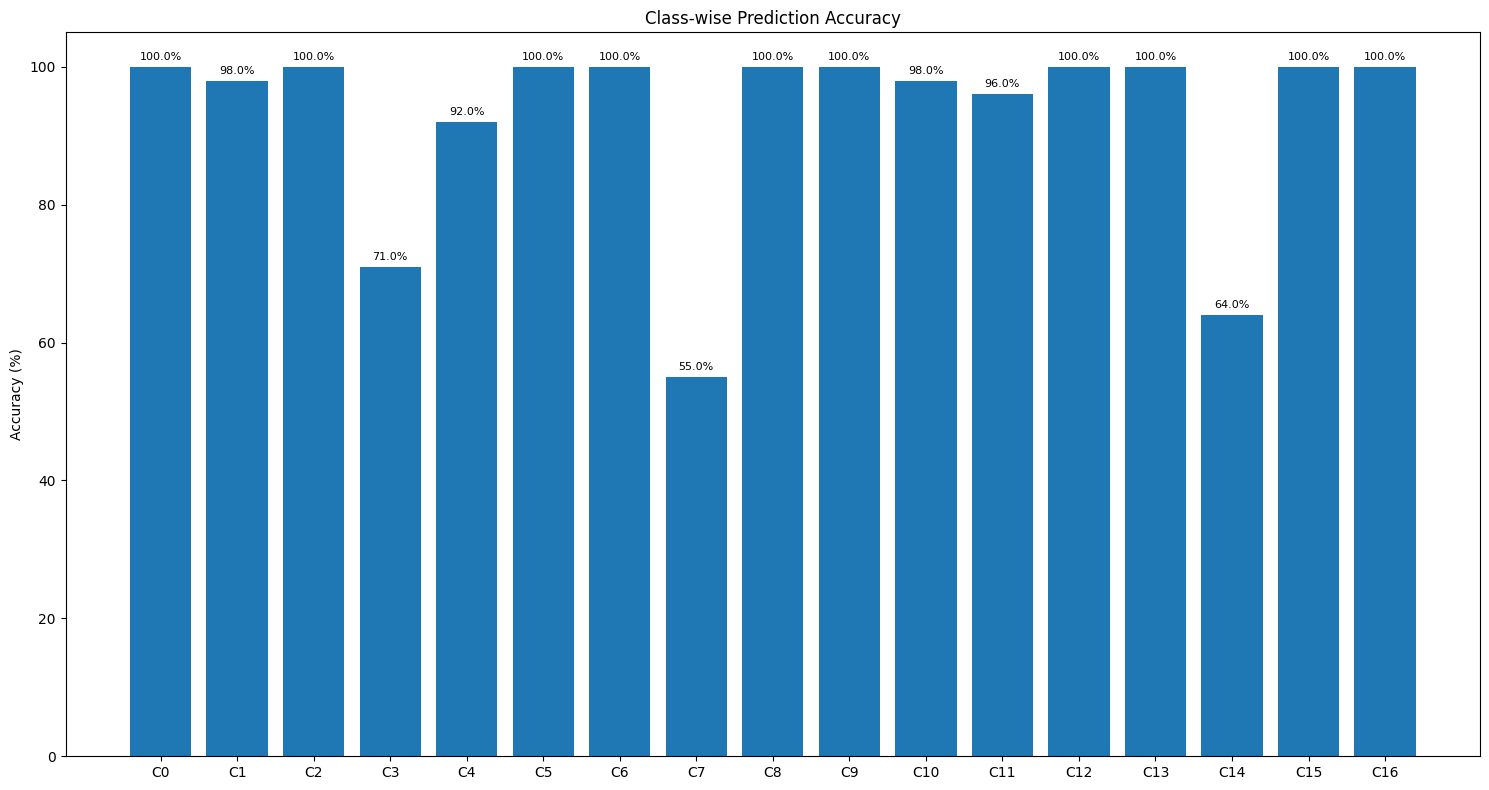

Worst 3 classes:
Class 7: 55.0%
Class 14: 64.0%
Class 3: 71.0%


In [12]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("../data/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")

In [13]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    fold_model.load_state_dict(state_dict)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

Using ensemble of all 5 fold models for inference


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [14]:
# # load model
# model = timm.create_model(
#     model_name,
#     pretrained=True,
#     num_classes=17
# ).to(device)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=LR)

In [15]:
# for epoch in range(EPOCHS):
#     ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
#     ret['epoch'] = epoch

#     log = ""
#     for k, v in ret.items():
#       log += f"{k}: {v:.4f}\n"
#     print(log)

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [16]:
# preds_list = []

# model.eval()
# for image, _ in tqdm(tst_loader):
#     image = image.to(device)

#     with torch.no_grad():
#         preds = model(image)
#     preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

In [17]:
# pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
# pred_df['target'] = preds_list

In [18]:
# sample_submission_df = pd.read_csv("../data/sample_submission.csv")
# assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [19]:
# pred_df.to_csv("pred.csv", index=False)

In [20]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [21]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [22]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        return augmented_images, target

In [23]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    essential_tta_transforms
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=64,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [24]:
def ensemble_tta_inference(models, loader, transforms, confidence_threshold=0.9):
    """5-Fold 모델 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc="Ensemble TTA")):
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for images in images_list:
                    images = images.to(device)
                    preds = model(images)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

In [25]:
# 앙상블 TTA 실행
print("Starting Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    confidence_threshold=0.9
)

Starting Ensemble TTA inference...


Ensemble TTA: 100%|██████████| 50/50 [13:23<00:00, 16.06s/it]


In [26]:
# TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

In [27]:
# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()

In [28]:
# TTA 결과 저장
tta_pred_df.to_csv("../submission/choice.csv", index=False)
print("TTA predictions saved")

print("TTA Prediction sample:")

TTA predictions saved
TTA Prediction sample:


In [29]:
tta_pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2
